## What the fake distributions should converge to

In [1]:
import numpy as np

import cvxpy as cvx

import matplotlib.cm as cm
from matplotlib import pyplot

from scipy import stats
import scipy.misc

%matplotlib inline

In [2]:
def rel_H(x, y):
    # relative entropy in Boyd
    return cvx.sum(cvx.kl_div(x, y) + x - y)

def solve_improved_gan(*hists):
    hists = list(hists)
    nbins = len(hists[0])
    f0 = cvx.Variable(nbins)
    constraints = [cvx.sum(f0) == 1, f0 >= 0]
    hists.insert(0,f0)
    M = len(hists)
    favg = f0
    freal = 0
    for i in range(1,M):
        favg += hists[i]
        freal += hists[i]

    loss = 0
    for fi in hists:
        # loss += rel_H((h - fi)/(M-1), h/M)
        loss += rel_H(fi, freal/M)
        #loss += rel_H(fi, (h-f0)/(M-1))

    obj = cvx.Minimize(loss)
    prob = cvx.Problem(obj, constraints)

    prob.solve()

    return f0.value

def solve_mode_gan(*hists):
    hists = list(hists)
    nbins = len(hists[0])
    f0 = cvx.Variable(nbins)
    constraints = [cvx.sum(f0) == 1, f0 >= 0]
    hists.insert(0,f0)
    M = len(hists)
    h = f0
    h0 = 0
    for i in range(1,M):
        h += hists[i]
        h0 += hists[i]
    flstar = np.max(hists[1:],axis=0)

    loss = rel_H(f0, flstar)

    obj = cvx.Minimize(loss)
    prob = cvx.Problem(obj, constraints)

    prob.solve()

    return f0.value

In [3]:
def density_for_2d_samples(samples):
    x_range = (0,8)
    y_range = (0,8)
    nxb = int((x_range[1] - x_range[0]) * 5)
    nyb = int((y_range[1] - y_range[0]) * 5)
    nbins = (80,80)
    tbins = np.prod(nbins)


    sampx = samples[:,0]
    sampy = samples[:,1]
    H, xedges, yedges = np.histogram2d(sampx, sampy, nbins, [x_range, y_range], normed=True)
    return H.reshape((tbins,))

In [4]:
n_examples = 100000
K = 10
xs = 2*np.cos(np.linspace(0,2*np.pi, K,endpoint=False)) + 4
ys = 2*np.sin(np.linspace(0,2*np.pi, K,endpoint=False)) + 4
variances = [(2/8.0,2/4.0)] * K
mus = list(zip(xs,ys))

dataloader = []
hists = []
for i in range(K):
    # specific to circle
    class_data = np.random.normal(0, variances[i], (n_examples,2))
    t = 2*np.pi*i/float(K)
    rot_mat = np.array([ [np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)] ])
    rotated_data = np.dot(rot_mat, class_data.T).T
    dataloader.append(rotated_data + np.array(mus[i]))
    hists.append(density_for_2d_samples(rotated_data + np.array(mus[i])))

In [5]:
f0 = solve_mode_gan(*hists)
nbinsT = (80,80)
H0 = f0.reshape(nbinsT)
scalef = 1+(200 // 80)
Hlarge = scipy.misc.imresize(H0, scalef*np.array(H0.shape))

/scratch0/ilya/locDoc/miniconda2/envs/venvcuda10/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


In [6]:
f0 = solve_improved_gan(*hists)
nbinsT = (80,80)
H0 = f0.reshape(nbinsT)
scalef = 1+(200 // 80)
Hlarge2 = scipy.misc.imresize(H0, scalef*np.array(H0.shape))

/scratch0/ilya/locDoc/miniconda2/envs/venvcuda10/lib/python3.6/site-packages/cvxpy/atoms/elementwise/kl_div.py:36: RuntimeWarning: invalid value encountered in true_divide
  return xlogy(x, x/y) - x + y
/scratch0/ilya/locDoc/miniconda2/envs/venvcuda10/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


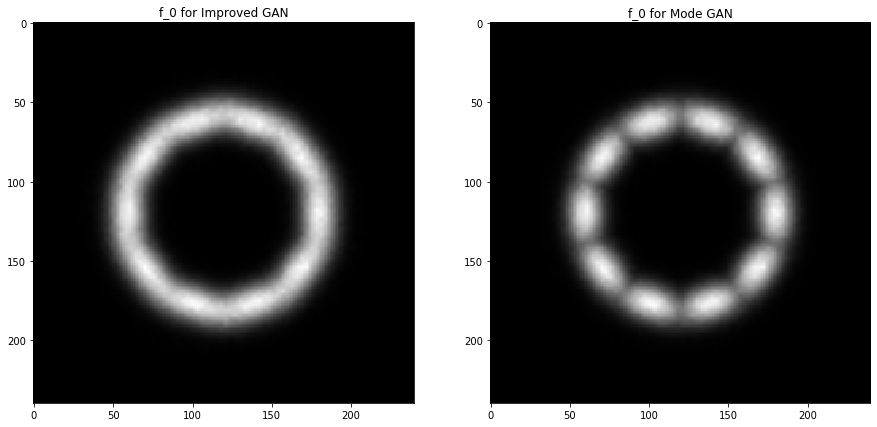

In [7]:
fig, (ax1,ax2) = pyplot.subplots(1,2,figsize=(15,15))

im = ax1.imshow(np.flipud(Hlarge2.T), cmap=cm.gray)
ax1.set_title('f_0 for Improved GAN')
im = ax2.imshow(np.flipud(Hlarge.T), cmap=cm.gray)
ax2.set_title('f_0 for Mode GAN')

fig.show()